In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import h5py
from hdf5plotter import h5ls
from brownian import Cantilever, BrownianMotionFitter, get_data, u, Pf, calc_P_x0
from stanhelper import *
import pystan

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
fh = h5py.File('brownianallpts155452.h5', 'r')
d = fh2data(fh, 61960, 62040, 62000, 3.5, 28000, sigma_fc=1, sigma_Q=2500, sigma_kc=3.5, sigma_Pdet=2e-7)

# Brownian motion data

- Example dataset below:

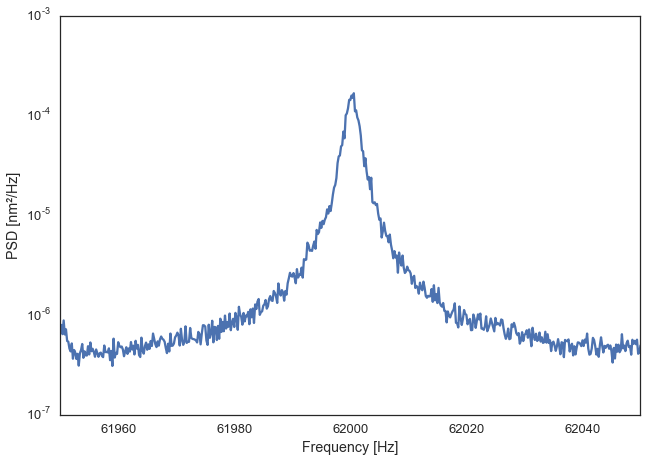

In [3]:
plt.semilogy(fh['f_subset'][:], np.mean(fh['PSD_subset'][:], 0))
plt.xlim(61950, 62050)
plt.ylabel(u"PSD [nm²/Hz]")
plt.xlabel("Frequency [Hz]")

## Naive model

- Power spectral density of position fluctuation data $y_i$,
- at frequencies $f_i$, with
- standard error $\sigma_i$
- calculated from $N$ averages

$$
\begin{align}
\mu_i & = P(f_i, f_\text{c}, k_\text{c}, Q) + P_\text{det}& \\
y_i &\sim \mathcal{N}(\mu_i, \sigma_i)&
\end{align}
$$

``brownian`` python code to fit this model.

In [4]:
bmf = BrownianMotionFitter(*get_data('brownianallpts155452.h5'), T=298,
                          est_cant=Cantilever(f_c=62*u.kHz,
                                     k_c=3.5*u.N/u.m,
                                     Q=28000*u.dimensionless)
                          )
bmf.calc_fit(61960, 62040)


Residuals
-------------------------------------
        Mean: -3.21e-02
   Std. dev.: 1.45e-01


(<matplotlib.figure.Figure at 0x1034dff50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115c4af50>)

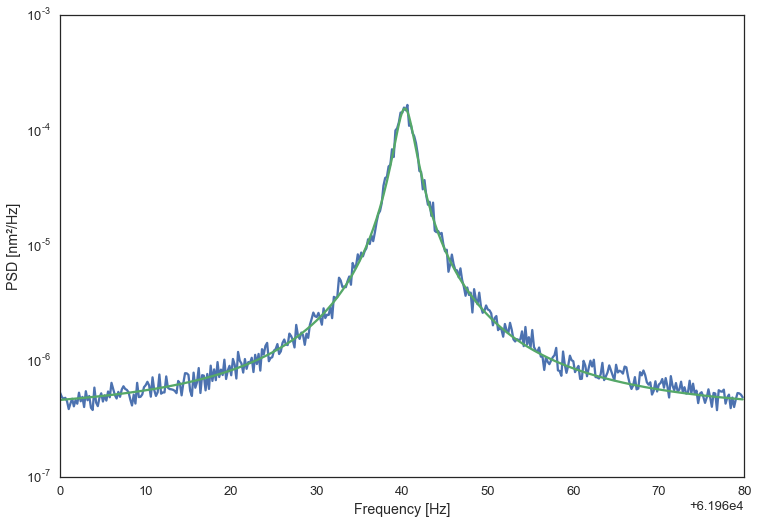

In [5]:
bmf.plot_fit()

(<matplotlib.figure.Figure at 0x1034df8d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b4a3890>)

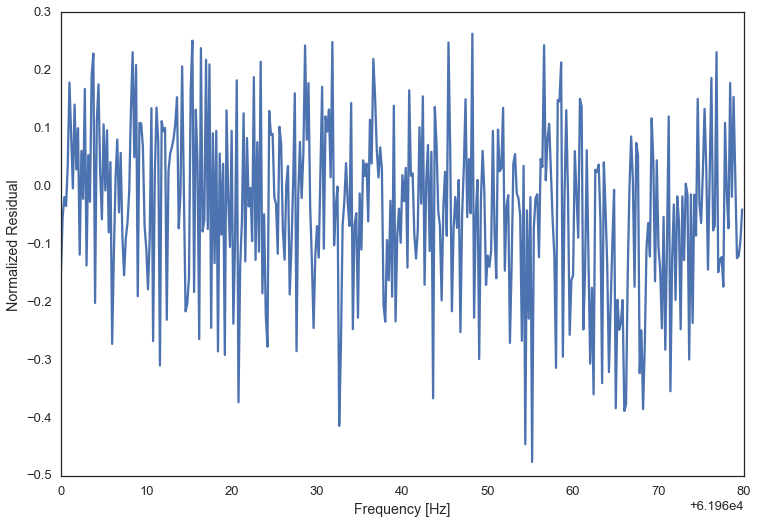

In [6]:
bmf.plot_reduced_residuals()

(<matplotlib.figure.Figure at 0x11be14bd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e138b90>)

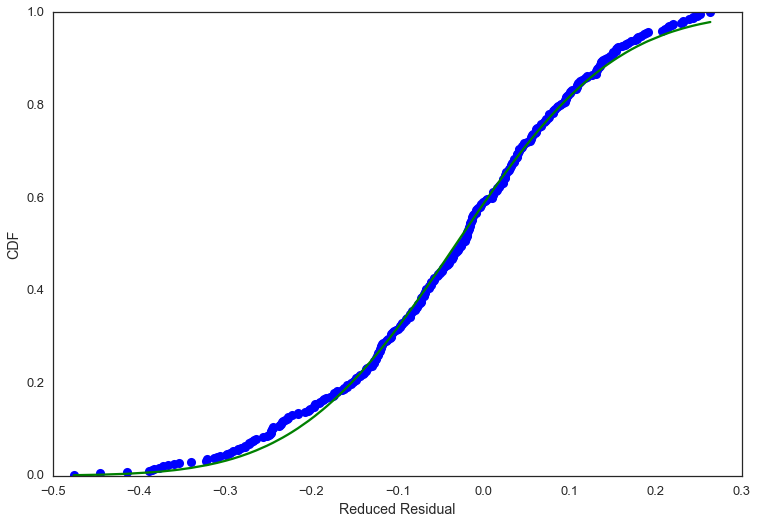

In [10]:
bmf.plot_cdf()

- Model poorly describes the data, even with $N=64$ averages.
- Makes sense; model ascribes significant probability to *negative* power spectral density!

In [8]:
print(bmf.report())


    Input
    -----------------------------------------------
    Temperature           T: 298 kelvin

    Estimates
    -----------------------------------------------
    Spring constant     k_c: 3.5 newton/meter
    Resonance frequency f_c: 62 kilohertz
    Quality factor        Q: 28000 dimensionless
    
    Fitting
    -----------------------------------------------
    Fit frequency min f_min: 61960 hertz
    Fit frequency max f_max: 62040 hertz

    Results
    -----------------------------------------------
    Resonance frequency f_c: 62000.31(3) hertz
    Spring constant     k_c: 7.3(2) newton/meter
    Quality Factor        Q: 2.68(7)×10⁴ dimensionless
    Detector Noise         : 3.35(7)×10⁻⁷ nanometer²/hertz
            


## What is an appropriate model?

- Power spectral density data positve
- Well-described by a mean $\mu$
- Has standard deviation $\sigma \propto \mu$ (see below)
- Maximum entropy distribution for positive variable with mean $\mu$ is an exponential,
    $$P(x) = \frac{1}{\mu}e^{-x/\mu}, \: \text{for} \: x >= 0$$


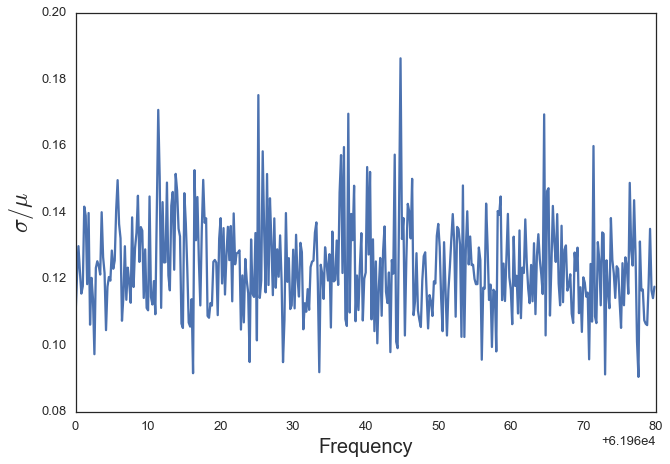

In [16]:
plt.plot(d['f'], d['y_err']/d['y'])
plt.xlabel("Frequency", fontsize=20)
plt.ylabel("$\\sigma / \\mu$", fontsize=24)

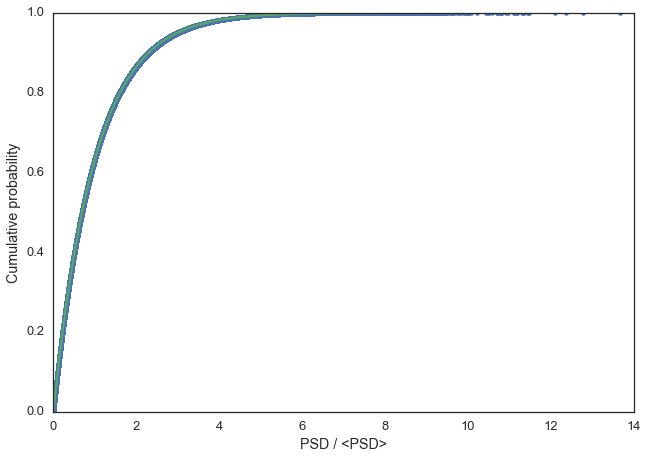

In [9]:
all_standardized = np.ravel(fh['PSD_subset'][:] / np.mean(fh['PSD_subset'][:], 0))
m_peak = (fh['f_subset'][:] > 61995) & (fh['f_subset'][:] < 62005)
peak_standardized = (fh['PSD_subset'][:] / np.mean(fh['PSD_subset'][:], 0))[:, m_peak]
all_sorted = np.sort(all_standardized)
y = np.arange(all_sorted.size)/all_sorted.size
plt.plot(all_sorted, y, '.')
plt.plot(all_sorted, 1-np.exp(-all_sorted))
plt.ylabel("Cumulative probability", fontsize=20)
plt.xlabel("$y / \\mu$", fontsize=24)

- Exponential distribution describes the observed data well
- Maximum entropy makes no additional assumptions about the data

# Exponential Model

Let's use our best guess, that each PSD is positive, with a mean $\mu_i$, given by $\mu_i = P(f_i, f_\text{c}, k_\text{c}, Q)$. Then we have,

$$
\begin{align}
\mu_i& =  P(f_i, f_\text{c}, k_\text{c}, Q) + P_\text{det}& \\
y_i & \sim \frac{1}{\mu_i}\exp(-\mu_i)& \\
\end{align}
$$

Note that we are now fitting the raw power spectral density data ($M$ averages). Stan code below:

# Baynesian fitting: same model

Let's use ``stan`` to examine the same naive model.

$$
\begin{align}
\mu_i &\sim P(x_i, f_\text{c}, k_\text{c}, Q) + P_\text{det}& \\
\sigma_i & \sim \frac{y_\sigma}{\sqrt{N}} \\
y &\sim \mathcal{N}(\mu, \sigma)&
\end{align}
$$

In [11]:
m = pystan.StanModel(model_code=naive_stan)

In [12]:
out = m.sampling(data=d, init=initial(d, Pdet=0.02), iter=4000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an 

In [13]:
samp = out.extract()

In [14]:
fc = d['mu_fc'] + np.median(samp['dfc'])
Q = np.median(samp['Q'])
kc = np.median(samp['kc'])
psd50 = Pf(d['f'], calc_P_x0(fc*u.Hz, Q, kc*u('N/m'), d['T']*u.K).to('nm^2/Hz').magnitude, fc, Q, np.mean(samp['Pdet'])*d['scale'])

(3e-07, 0.0005)

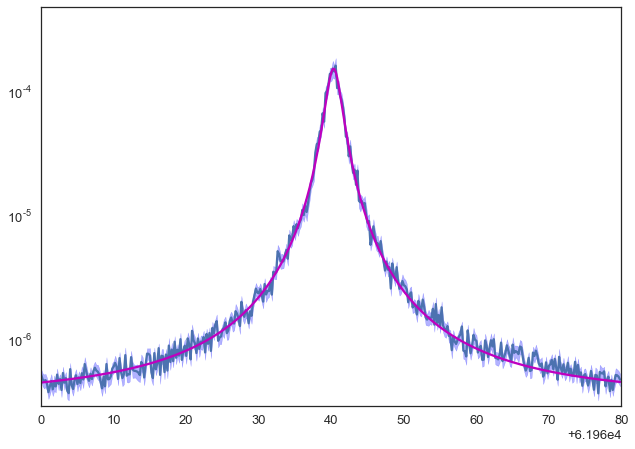

In [19]:
plt.semilogy(d['f'], d['y']*d['scale'])
plt.fill_between(d['f'], d['y']*d['scale']-d['y_err']*d['scale'], d['y']*d['scale']+d['y_err']*d['scale'],
                 color='b', alpha=0.3)
# plt.semilogy(d['f'], psd50, 'g-')
plt.semilogy(d['f'], psd50, 'm-')
# plt.semilogy(d['f'], Pfi(d, samp, 2000))
plt.ylim(3e-7, 5e-4)

(1e-06, 0.0003)

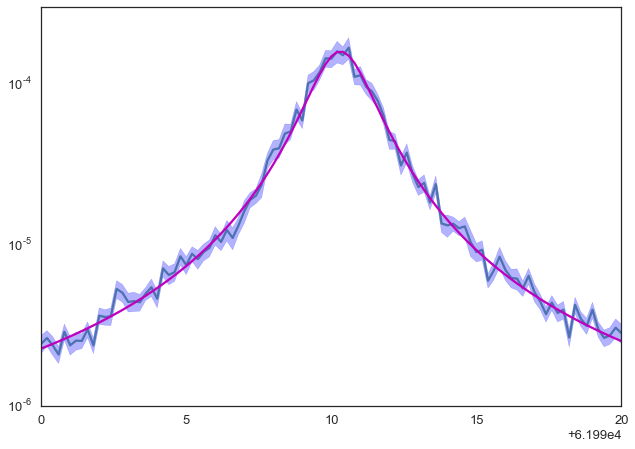

In [20]:
plt.semilogy(d['f'], d['y']*d['scale'])
plt.fill_between(d['f'], d['y']*d['scale']-d['y_err']*d['scale'], d['y']*d['scale']+d['y_err']*d['scale'],
                 color='b', alpha=0.3)
# plt.semilogy(d['f'], psd50, 'g-')
plt.semilogy(d['f'], psd50, 'm-')
# plt.semilogy(d['f'], Pfi(d, samp, 2000))
plt.xlim(61990, 62010)
plt.ylim(1e-6, 3e-4)

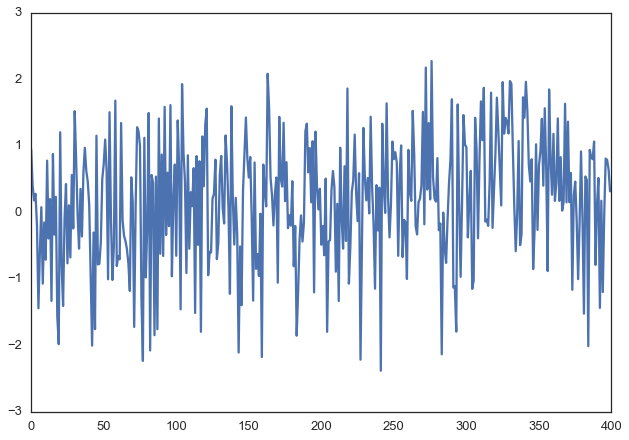

In [21]:
plt.plot( (d['y'] - (Pfi(d, samp, 1000) / d['scale'])) / (samp['k'][1000] * d['y']))

```
data {
  int<lower=0> N;
  int<lower=0> M;
  vector[N] f;
  vector[N] y[M];
 
  
  
  # Prior mean, standard deviations
  real mu_fc;
  real mu_kc;
  real mu_Q;
  real sigma_fc;
  real sigma_kc;
  real sigma_Q;
  real<lower=0> mu_Pdet;
  
  # Conversion factor, temperature
  real scale;
  real<lower=0> T;
}
parameters {
  real dfc;  # fc = dfc + mu_fc
  real<lower=0> kc;
  real<lower=0> Q;
  real<lower=0> Pdet;
}

model {
    vector[N] P;
    # Stan specifies exponential in rate beta = 1 / mu
    vector[N] beta;
    beta <- 1. ./ (((2 * 1.381e-5 * T) / (pi() * Q * kc)) / scale * (dfc + mu_fc)^3 ./
            ((f .* f - (dfc + mu_fc)^2) .* (f .* f - (dfc + mu_fc)^2) + f .* f * (dfc + mu_fc)^2 / Q^2)
            + Pdet);

    
    Pdet ~ exponential(inv(mu_Pdet));

    # Weakly informative priors on fit parameters
    dfc ~ normal(0, sigma_fc);
    kc ~ normal(mu_kc, sigma_kc);
    Q ~ normal(mu_Q, sigma_Q);
    
    for (i in 1:M) {
        y[i] ~ exponential(beta);
    }
}
```

In [17]:
mexp = pystan.StanModel(model_code=exp_stan)

In [18]:
dexp = fh2data_all(fh, 61954, 62046, 62000, 3.5, 28000, sigma_fc=1, sigma_Q=2500, sigma_kc=3.5, sigma_Pdet=2e-7)

In [19]:
exp_out = mexp.sampling(data=dexp, init=initial(dexp), iter=3000, chains=3, warmup=1000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)


In [20]:
exp_out

Inference for Stan model: anon_model_b8936cf5b921b8fd3b58204ce05d8592.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.3e-4   0.03   0.26    0.3   0.31   0.33   0.36 6000.0    1.0
kc     7.03  1.9e-3   0.14   6.75   6.93   7.03   7.12   7.32 6000.0    1.0
Q     2.7e4    8.07 624.94  2.5e4  2.6e4  2.7e4  2.7e4  2.8e4 6000.0    1.0
Pdet   0.05  1.0e-5 8.0e-4   0.05   0.05   0.05   0.05   0.05 6000.0    nan
lp__  1.8e4    0.02   1.42  1.8e4  1.8e4  1.8e4  1.8e4  1.8e4 6000.0    1.0

Samples were drawn using NUTS(diag_e) at Tue Feb 16 15:01:08 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

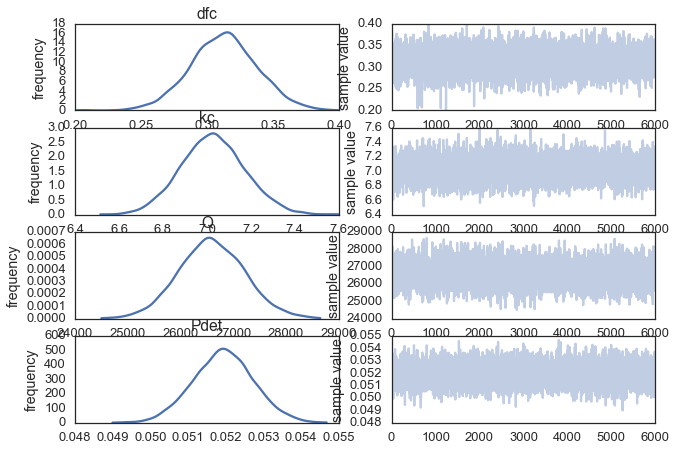

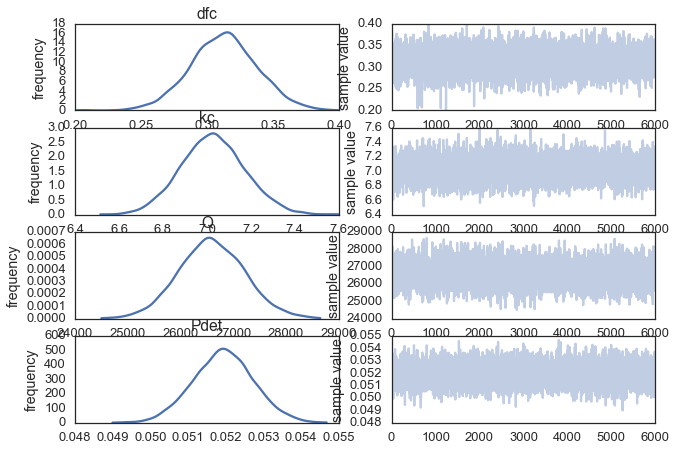

In [21]:
exp_out.traceplot()

In [22]:
exp_samp = exp_out.extract()

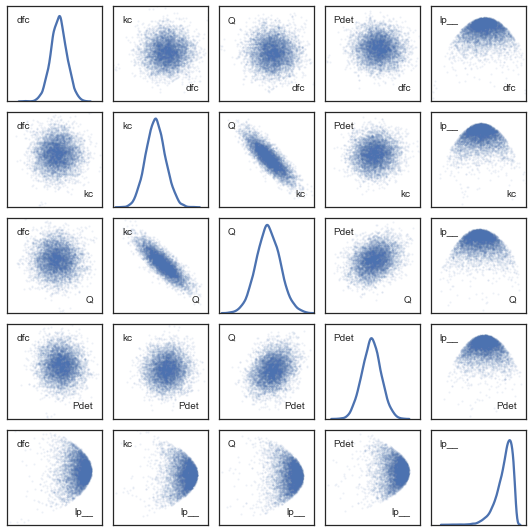

In [23]:
fig, ax = plot_all_traces(exp_samp)

In [24]:
HDI_from_MCMC(exp_samp['kc'], 0.95)

(6.7434802992266656, 7.3128822989015942)

NameError: global name 'Pf' is not defined

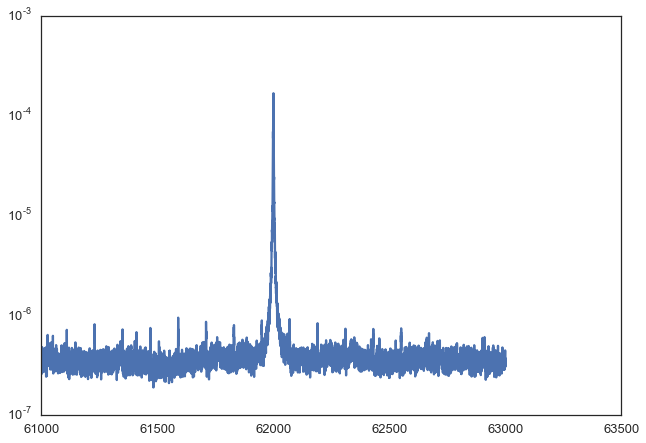

In [25]:
f = fh['f_subset'][:]
plt.semilogy(f, np.mean(fh['PSD_subset'][:], 0))
plt.semilogy(dexp['f'], Pfi(dexp, exp_samp, 2500))
plt.xlim(61950, 62050)

# Gamma distribution

- Now that we know this exponential model works, we can also fit all of the data together (as the naive model did)
- The sum of exponential distributions is a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)
- Model:
    $$
    \begin{align}
    \mu_i & = P(f_i, f_\text{c}, k_\text{c}, Q) + P_\text{det}& \\
    y_i &\sim \Gamma(M, \mu_i \,/ \,M)&
    \end{align}
    $$
- This model samples very quickly, gives equivalent information / parameter estimates.

In [26]:
gammod = pystan.StanModel(model_code=gamma_code, mod)

In [27]:
d = fh2data(fh, 61954, 62046, 62000, 3.5, 28000, sigma_fc=1, sigma_Q=2500, sigma_kc=3.5, sigma_Pdet=2e-7)

In [30]:
# gammod.sampling(data=d, init=initial(dexp), chains=3, iter=100)
out_gam = gammod.sampling(data=d, init=initial(dexp), chains=3, iter=3000, warmup=1000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)


In [35]:
out_gam

Inference for Stan model: anon_model_6b1131171a1e0ed7706776bbffa264fb.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.3e-4   0.03   0.26    0.3   0.31   0.33   0.36 6000.0    1.0
kc     7.03  1.9e-3   0.15   6.75   6.93   7.03   7.13   7.32 6000.0    1.0
Q     2.7e4    8.36 647.66  2.5e4  2.6e4  2.7e4  2.7e4  2.8e4 6000.0    1.0
Pdet   0.05  1.1e-5 8.3e-4   0.05   0.05   0.05   0.05   0.05 6000.0    nan
lp__  1.4e5    0.02   1.46  1.4e5  1.4e5  1.4e5  1.4e5  1.4e5 6000.0    1.0

Samples were drawn using NUTS(diag_e) at Tue Feb 16 15:11:58 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [36]:
exp_out

Inference for Stan model: anon_model_b8936cf5b921b8fd3b58204ce05d8592.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.3e-4   0.03   0.26    0.3   0.31   0.33   0.36 6000.0    1.0
kc     7.03  1.9e-3   0.14   6.75   6.93   7.03   7.12   7.32 6000.0    1.0
Q     2.7e4    8.07 624.94  2.5e4  2.6e4  2.7e4  2.7e4  2.8e4 6000.0    1.0
Pdet   0.05  1.0e-5 8.0e-4   0.05   0.05   0.05   0.05   0.05 6000.0    nan
lp__  1.8e4    0.02   1.42  1.8e4  1.8e4  1.8e4  1.8e4  1.8e4 6000.0    1.0

Samples were drawn using NUTS(diag_e) at Tue Feb 16 15:01:08 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

# Summary

- Different credible regions for parameters 95 percent credible region for $k_\text{c}$ is $6.75 \: \text{to} \: 7.32 \: \text{N/m}$ vs $6.91 \: \text{to} \: 7.56 \: \text{N/m}$
- Better motivated
- Easy to model / sample from non-normal distributions 

# Extra: Baynesian fitting of naive model

Let's use ``stan`` to examine the same naive model.

$$
\begin{align}
\mu_i &\sim P(x_i, f_\text{c}, k_\text{c}, Q) + P_\text{det}& \\
\sigma_i & \sim \frac{y_\sigma}{\sqrt{N}} \\
y &\sim \mathcal{N}(\mu, \sigma)&
\end{align}
$$

In [33]:
m = pystan.StanModel(model_code=naive_stan)
out = m.sampling(data=d, init=initial(d, Pdet=0.02), iter=3000, warmup=1000, chains=3)
samp = out.extract()
fc = d['mu_fc'] + np.median(samp['dfc'])
Q = np.median(samp['Q'])
kc = np.median(samp['kc'])
psd50 = Pf(d['f'], calc_P_x0(fc*u.Hz, Q, kc*u('N/m'), d['T']*u.K).to('nm^2/Hz').magnitude, fc, Q, np.mean(samp['Pdet'])*d['scale'])

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)


In [34]:
out

Inference for Stan model: anon_model_b01d96fd8d8d73705526c9987a94f2aa.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.8e-4   0.03   0.26   0.29   0.31   0.33   0.37 6000.0    1.0
kc     7.23  2.1e-3   0.16   6.91   7.12   7.23   7.34   7.56 6000.0    1.0
Q     2.7e4    8.91  690.2  2.6e4  2.6e4  2.7e4  2.7e4  2.8e4 6000.0    1.0
Pdet   0.05  1.1e-5 8.6e-4   0.05   0.05   0.05   0.05   0.05 6000.0    nan
k      0.14  6.1e-5 4.8e-3   0.13   0.14   0.14   0.14   0.15 6000.0    1.0
lp__ 1421.3    0.02   1.57 1417.5 1420.5 1421.6 1422.5 1423.4 6000.0    1.0

Samples were drawn using NUTS(diag_e) at Tue Feb 16 15:13:46 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

(3e-07, 0.0005)

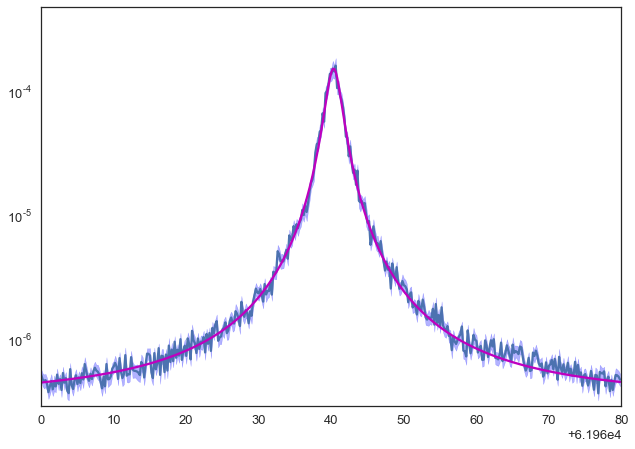

In [19]:
# plt.semilogy(d['f'], d['y']*d['scale'])
# plt.fill_between(d['f'], d['y']*d['scale']-d['y_err']*d['scale'], d['y']*d['scale']+d['y_err']*d['scale'],
#                  color='b', alpha=0.3)
# # plt.semilogy(d['f'], psd50, 'g-')
# plt.semilogy(d['f'], psd50, 'm-')
# # plt.semilogy(d['f'], Pfi(d, samp, 2000))
# plt.ylim(3e-7, 5e-4)

(1e-06, 0.0003)

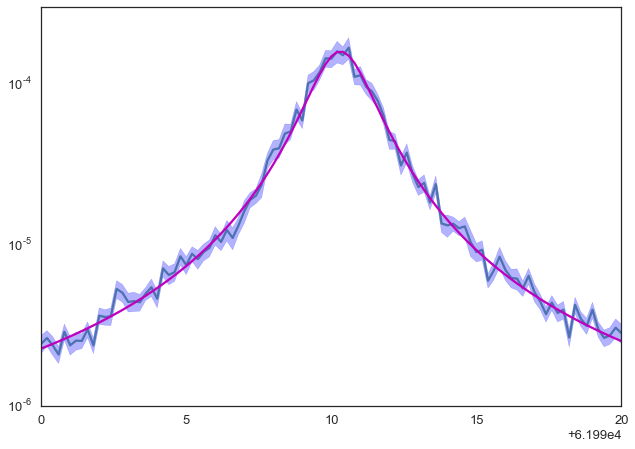

In [20]:
# plt.semilogy(d['f'], d['y']*d['scale'])
# plt.fill_between(d['f'], d['y']*d['scale']-d['y_err']*d['scale'], d['y']*d['scale']+d['y_err']*d['scale'],
#                  color='b', alpha=0.3)
# # plt.semilogy(d['f'], psd50, 'g-')
# plt.semilogy(d['f'], psd50, 'm-')
# # plt.semilogy(d['f'], Pfi(d, samp, 2000))
# plt.xlim(61990, 62010)
# plt.ylim(1e-6, 3e-4)